In [1]:
#!/usr/bin/env python3
import os
import cv2
import torch
import numpy as np
import matplotlib
# matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import zoom

from utils import *
from config import *
from dataset import CarlaDataset  
from rcilv3d import RCILv3D

/home/pavlos/venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
CARLA_BASE_DIR = "/media/pavlos/HDD/Datasets/TeslaPilot/carla"
GAN_BASE_DIR = "/media/pavlos/HDD/Datasets/TeslaPilot/carla-cityscapes"
# TOWNS = TRAIN_TOWN_LIST + EVAL_TOWN_LIST
TOWNS = ["Town01", "Town02", "Town03", "Town04", "Town05", "Town06", "Town07"]
# TOWNS = ["Town06"]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print("[+] Using device:", device)

[+] Using device: cuda


In [4]:
carla_dataset = CarlaDataset(
  base_dir=CARLA_BASE_DIR,
  townslist=TOWNS,
  image_size=IMAGE_SIZE,
  use_imagenet_norm=USE_IMAGENET_NORM,
  sequence_size=SEQUENCE_SIZE,
  inference=True
)

[CarlaDataset] Loading Town07: 100%|██████████| 7/7 [00:08<00:00,  1.23s/it]


In [5]:
gan_dataset = CarlaDataset(
  base_dir=GAN_BASE_DIR,
  townslist=TOWNS,
  image_size=IMAGE_SIZE,
  use_imagenet_norm=USE_IMAGENET_NORM,
  sequence_size=SEQUENCE_SIZE,
  inference=True
)

[CarlaDataset] Loading Town07: 100%|██████████| 7/7 [00:07<00:00,  1.07s/it]


In [6]:
idx = 200

# TOWN_LEN = 10
# EPISODE_LEN = 1000
# town = 4
# episode = 8 
# offset = 0
# idx = town * TOWN_LEN + episode * EPISODE_LEN + offset

print(f"{idx}/{len(gan_dataset)}")
carla_sample = carla_dataset[idx]
gan_sample = gan_dataset[idx]

200/60927


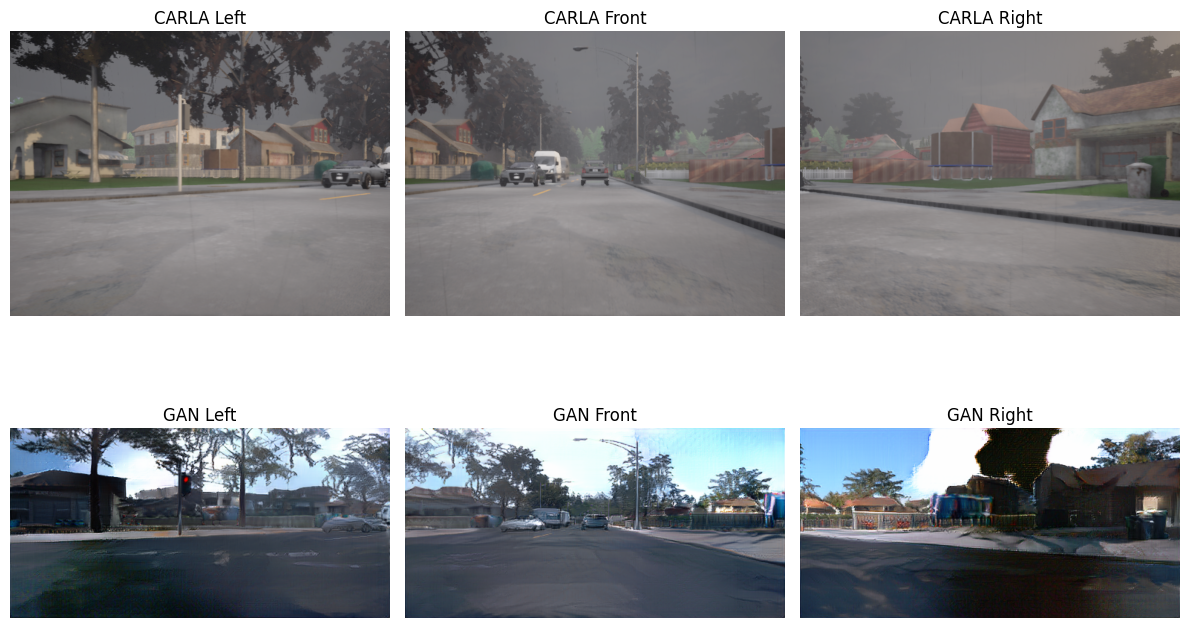

In [7]:
import matplotlib.pyplot as plt

t = 7

# CARLA (top row)
carla_left  = carla_sample[0]["rgb_left_disp"][t]
carla_front = carla_sample[0]["rgb_front_disp"][t]
carla_right = carla_sample[0]["rgb_right_disp"][t]

# GAN (bottom row)
gan_left  = gan_sample[0]["rgb_left_disp"][t]
gan_front = gan_sample[0]["rgb_front_disp"][t]
gan_right = gan_sample[0]["rgb_right_disp"][t]

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# ---- Top row: CARLA ----
axes[0, 0].imshow(carla_left)
axes[0, 0].set_title("CARLA Left")
axes[0, 0].axis("off")

axes[0, 1].imshow(carla_front)
axes[0, 1].set_title("CARLA Front")
axes[0, 1].axis("off")

axes[0, 2].imshow(carla_right)
axes[0, 2].set_title("CARLA Right")
axes[0, 2].axis("off")

# ---- Bottom row: GAN ----
axes[1, 0].imshow(gan_left)
axes[1, 0].set_title("GAN Left")
axes[1, 0].axis("off")

axes[1, 1].imshow(gan_front)
axes[1, 1].set_title("GAN Front")
axes[1, 1].axis("off")

axes[1, 2].imshow(gan_right)
axes[1, 2].set_title("GAN Right")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

In [127]:
from rcilv3d import RCILv3D, CILv3DConfig

CARLA_MODEL_PATH = "./checkpoints/RCILv3D/CILv3D_lookahead_5_best.pt"
cfg = CILv3DConfig()
cfg.freeze_backbone = False

carla_model = RCILv3D(device=device)
checkpoint = torch.load(CARLA_MODEL_PATH, weights_only=False, map_location=device)
carla_model.load_state_dict(checkpoint["model"])
carla_model.to(device)
carla_model.eval()
print(f"[+] CARLA Model {CARLA_MODEL_PATH} loaded successfully")

[*] RCILv3D configuration:
  sequence_size: 8
  state_size: 7
  command_size: 6
  filters_1d: 32
  embedding_size: 512
  transformer_heads: 8
  transformer_layers: 6
  freeze_backbone: True
  transformer_dropout: 0.4
  linear_dropout: 0.4
  use_revin: False
  uniformer_version: UniformerVersion.BASE



/home/pavlos/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


KeyError: 'model'

In [8]:
from rcilv3d import RCILv3D, RCILv3DConfig

cfg = RCILv3DConfig()
cfg.freeze_backbone = False
GAN_MODEL_PATH = "./checkpoints/sim2real_artifacts_val/RCILv3D_artifacts_val_best.pt"

gan_model = RCILv3D(cfg=cfg, device=device)
checkpoint = torch.load(GAN_MODEL_PATH, weights_only=False, map_location=device)
gan_model.load_state_dict(checkpoint["model"])
gan_model.to(device)
gan_model.eval()
print(f"[+] CARLA Model {GAN_MODEL_PATH} loaded successfully")


[*] RCILv3D configuration:
  sequence_size: 8
  state_size: 7
  command_size: 6
  filters_1d: 32
  embedding_size: 512
  transformer_heads: 8
  transformer_layers: 6
  freeze_backbone: False
  transformer_dropout: 0.4
  linear_dropout: 0.4
  use_revin: False
  uniformer_version: UniformerVersion.BASE



/home/pavlos/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[+] CARLA Model ./checkpoints/sim2real_artifacts_val/RCILv3D_artifacts_val_best.pt loaded successfully


In [9]:
LEFT = gan_sample[0]["rgb_left"].unsqueeze(0).to(device)
FRONT = gan_sample[0]["rgb_front"].unsqueeze(0).to(device)
RIGHT = gan_sample[0]["rgb_right"].unsqueeze(0).to(device)
STATES = gan_sample[0]["states"].unsqueeze(0).to(device)
CMD = gan_sample[0]["commands"].unsqueeze(0).to(device)
Y = gan_sample[1].to(device)

out, layerouts = gan_model(LEFT, FRONT, RIGHT, STATES, CMD)
layerout_left, layerout_front, layerout_right = layerouts
layerout_left.retain_grad()
layerout_front.retain_grad()
layerout_right.retain_grad()

# Steering (action 0), first future timestep
score = out[:, 0, 0].sum()

gan_model.zero_grad()
score.backward()


In [10]:
import numpy as np
import cv2
import torch
from scipy.ndimage import zoom

def gradcam_video(RGB_vid, layerout, use_imagenet_norm=True, alpha=0.3):
    """
    RGB_vid:  (1, 3, T, H, W)
    layerout: (1, C, T, H, W)
    """
    grads = layerout.grad
    feats = layerout.detach()

    # Compute weights and CAM
    weights = grads.mean(dim=(3, 4), keepdim=True)
    cam = (weights * feats).sum(dim=1)
    cam = torch.relu(cam)[0]  # (T, H, W)
    cam = cam.cpu().numpy()

    # Resize CAM to match image
    T, H, W = cam.shape
    cam = zoom(cam, (1, RGB_vid.shape[3]/H, RGB_vid.shape[4]/W))

    # Normalize CAM to [0,1]
    cam -= cam.min()
    cam /= cam.max() + 1e-8

    heatmaps = []
    for t in range(cam.shape[0]):
        # Colorize
        heat = cv2.applyColorMap(np.uint8(255 * cam[t]), cv2.COLORMAP_JET)  # BGR
        heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB) / 255.0               # convert to RGB, [0,1]

        # Denormalize input frame
        img = RGB_vid[0, :, t]
        if use_imagenet_norm:
            mean = torch.tensor([0.485, 0.456, 0.406], device=img.device).view(3,1,1)
            std  = torch.tensor([0.229, 0.224, 0.225], device=img.device).view(3,1,1)
            rgb = (img * std + mean).permute(1,2,0).cpu().numpy()
        else:
            rgb = img.permute(1,2,0).cpu().numpy()

        rgb = np.clip(rgb, 0, 1)

        # Blend: use low alpha for heatmap to avoid over-saturation
        overlay = (1 - alpha) * rgb + alpha * heat
        overlay = np.clip(overlay, 0, 1)
        heatmaps.append(overlay)

    return heatmaps

In [11]:
from PIL import Image
import torch
from torchvision import transforms

gan_left  = gan_sample[0]["rgb_left_disp"]   # (8, 256, 512, 3)
gan_front = gan_sample[0]["rgb_front_disp"]
gan_right = gan_sample[0]["rgb_right_disp"]

image_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

def process_video(frames):
    # frames: (T, H, W, 3)
    tensors = []
    for t in range(frames.shape[0]):
        pil_img = Image.fromarray(frames[t].astype('uint8'))
        tensor = transform(pil_img)  # (3, 224, 224)
        tensors.append(tensor)
    # Stack along frame dimension -> (3, T, H, W)
    video_tensor = torch.stack(tensors, dim=1)  # (3, 8, 224, 224)
    # Add batch dimension -> (1, 3, 8, 224, 224)
    return video_tensor.unsqueeze(0)

gan_left_tensor  = process_video(gan_left)
gan_front_tensor = process_video(gan_front)
gan_right_tensor = process_video(gan_right)

alpha = 0.2

left_cams  = gradcam_video(gan_left_tensor,  layerout_left, alpha=alpha)
front_cams = gradcam_video(gan_front_tensor, layerout_front, alpha=alpha)
right_cams = gradcam_video(gan_right_tensor, layerout_right, alpha=alpha)

AttributeError: 'NoneType' object has no attribute 'mean'

In [26]:
LEFT = carla_sample[0]["rgb_left"].unsqueeze(0).to(device)
FRONT =carla_sample[0]["rgb_front"].unsqueeze(0).to(device)
RIGHT =carla_sample[0]["rgb_right"].unsqueeze(0).to(device)
STATES =carla_sample[0]["states"].unsqueeze(0).to(device)
CMD = carla_sample[0]["commands"].unsqueeze(0).to(device)
Y =  carla_sample[1].to(device)

out, layerouts = gan_model(LEFT, FRONT, RIGHT, STATES, CMD)
layerout_left, layerout_front, layerout_right = layerouts
layerout_left.retain_grad()
layerout_front.retain_grad()
layerout_right.retain_grad()

# Steering (action 0), first future timestep
score = out[:, 0, 0].sum()

gan_model.zero_grad()
score.backward()


In [27]:
from PIL import Image
import torch
from torchvision import transforms

carla_left  = carla_sample[0]["rgb_left_disp"]   # (8, 256, 512, 3)
carla_front = carla_sample[0]["rgb_front_disp"]
carla_right = carla_sample[0]["rgb_right_disp"]

image_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

def process_video(frames):
    # frames: (T, H, W, 3)
    tensors = []
    for t in range(frames.shape[0]):
        pil_img = Image.fromarray(frames[t].astype('uint8'))
        tensor = transform(pil_img)  # (3, 224, 224)
        tensors.append(tensor)
    # Stack along frame dimension -> (3, T, H, W)
    video_tensor = torch.stack(tensors, dim=1)  # (3, 8, 224, 224)
    # Add batch dimension -> (1, 3, 8, 224, 224)
    return video_tensor.unsqueeze(0)

carla_gan_left_tensor  = process_video(gan_left)
carla_gan_front_tensor = process_video(gan_front)
carla_gan_right_tensor = process_video(gan_right)

alpha = 0.2

carla_left_cams  = gradcam_video(carla_gan_left_tensor,  layerout_left, alpha=alpha)
carla_front_cams = gradcam_video(carla_gan_front_tensor, layerout_front, alpha=alpha)
carla_right_cams = gradcam_video(carla_gan_right_tensor, layerout_right, alpha=alpha)

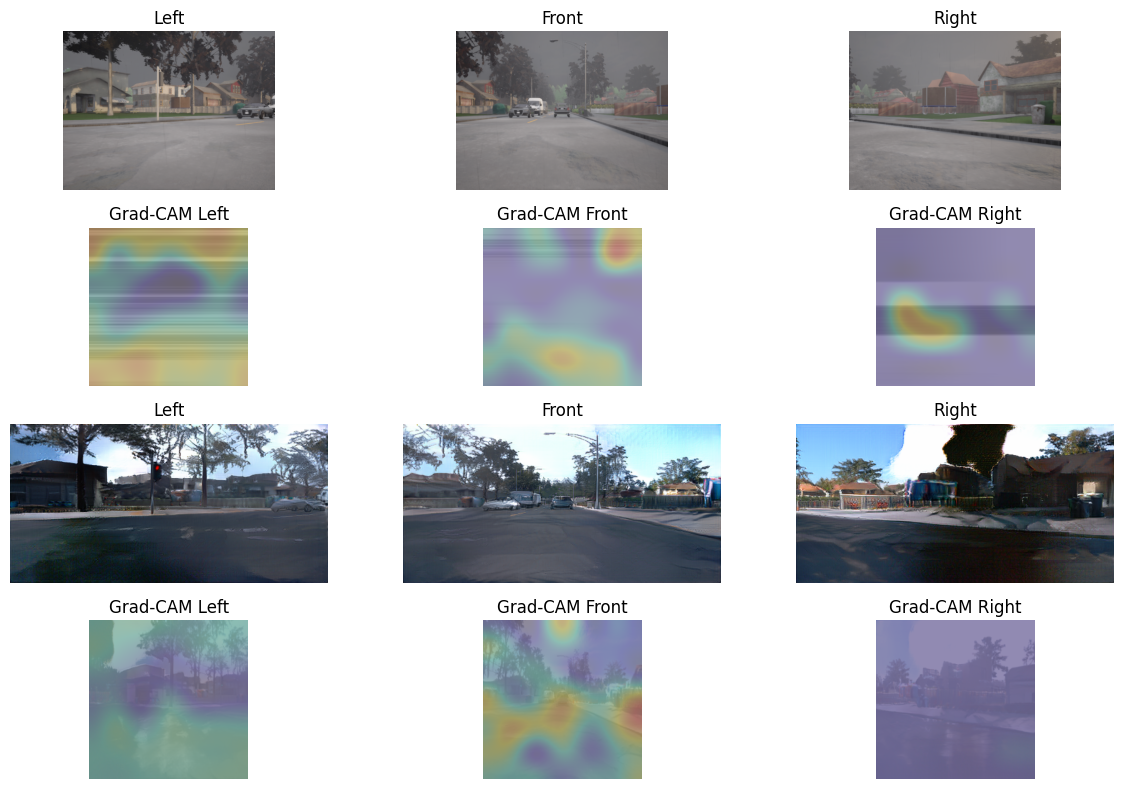

In [32]:
import matplotlib.pyplot as plt

t = 7
t_cam = min(t, len(left_cams) - 1)

fig, axes = plt.subplots(4, 3, figsize=(12, 8))


carla_left  = carla_sample[0]["rgb_left_disp"][t]
carla_front = carla_sample[0]["rgb_front_disp"][t]
carla_right = carla_sample[0]["rgb_right_disp"][t]

gan_left  = gan_sample[0]["rgb_left_disp"][t]
gan_front = gan_sample[0]["rgb_front_disp"][t]
gan_right = gan_sample[0]["rgb_right_disp"][t]

# Raw (denormalized)
axes[0,0].imshow(carla_left)
axes[0,0].set_title("Left")
axes[0,0].axis("off")

axes[0,1].imshow(carla_front)
axes[0,1].set_title("Front")
axes[0,1].axis("off")

axes[0,2].imshow(carla_right)
axes[0,2].set_title("Right")
axes[0,2].axis("off")

axes[1,0].imshow(carla_left_cams[t_cam])
axes[1,0].set_title("Grad-CAM Left")
axes[1,0].axis("off")

axes[1,1].imshow(carla_front_cams[t_cam])
axes[1,1].set_title("Grad-CAM Front")
axes[1,1].axis("off")

axes[1,2].imshow(carla_right_cams[t_cam])
axes[1,2].set_title("Grad-CAM Right")
axes[1,2].axis("off")


axes[2,0].imshow(gan_left)
axes[2,0].set_title("Left")
axes[2,0].axis("off")

axes[2,1].imshow(gan_front)
axes[2,1].set_title("Front")
axes[2,1].axis("off")

axes[2,2].imshow(gan_right)
axes[2,2].set_title("Right")
axes[2,2].axis("off")

# Grad-CAM
axes[3,0].imshow(left_cams[t_cam])
axes[3,0].set_title("Grad-CAM Left")
axes[3,0].axis("off")

axes[3,1].imshow(front_cams[t_cam])
axes[3,1].set_title("Grad-CAM Front")
axes[3,1].axis("off")

axes[3,2].imshow(right_cams[t_cam])
axes[3,2].set_title("Grad-CAM Right")
axes[3,2].axis("off")

plt.tight_layout()
plt.show()



In [13]:
def rcilv3d_gradcam(
    model,
    left_img,
    front_img,
    right_img,
    states,
    commands,
    control_idx=0,      # 0 = steering, 1 = acceleration
    future_t=0,         # which future timestep
    view="front",       # "left" | "front" | "right"
):
    model.eval()
    model.zero_grad()

    out, layerouts = model(left_img, front_img, right_img, states, commands)

    # select regression scalar
    target = out[0, future_t, control_idx]
    target.backward()

    view_map = {"left": 0, "front": 1, "right": 2}
    fmap = layerouts[view_map[view]]  # (B, C, T, H, W)

    grads = fmap.grad                 # (B, C, T, H, W)
    activations = fmap.detach()

    # Grad-CAM weights
    weights = grads.mean(dim=(2, 3, 4), keepdim=True)  # (B, C, 1, 1, 1)

    cam = (weights * activations).sum(dim=1)           # (B, T, H, W)
    cam = torch.relu(cam)

    # normalize per video
    cam -= cam.min()
    cam /= cam.max() + 1e-8

    return cam[0].cpu().numpy()  # (T, H, W)

def overlay_cam(rgb_video, cam, alpha=0.3):
    """
    rgb_video: (T,H,W,C), float in [0,1], RGB
    cam: (T,H,W), float in [0,1]
    Returns: list of (H,W,C) float images [0,1] ready for matplotlib
    """
    overlays = []

    for t in range(cam.shape[0]):
        # heatmap in BGR
        heat = cv2.applyColorMap(np.uint8(255 * cam[t]), cv2.COLORMAP_JET)

        # convert heatmap to RGB
        heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

        # rgb_video[t] is float [0,1], convert to uint8
        frame = np.uint8(rgb_video[t] * 255)

        # blend
        overlay = cv2.addWeighted(heat, alpha, frame, 1 - alpha, 0)

        # back to float [0,1] for matplotlib
        overlays.append(overlay.astype(np.float32) / 255.0)

    return overlays

import cv2
import numpy as np

def upsample_cam(cam, target_h=256, target_w=512):
    return np.stack([
        cv2.resize(cam[t], (target_w, target_h))
        for t in range(cam.shape[0])
    ])

# def denormalize_imagenet(tensor):
#     """
#     tensor: (C, T, H, W) torch tensor
#     """
#     mean = [0.485, 0.456, 0.406]
#     std = [0.229, 0.224, 0.225]
#     mean = torch.tensor(mean, device=tensor.device).view(3, 1, 1)
#     std = torch.tensor(std, device=tensor.device).view(3, 1, 1)

#     return tensor * std + mean

def denormalize_imagenet(tensor):
    """
    tensor: torch.Tensor of shape (C, T, H, W)
            assumed ImageNet-normalized twice
    returns: torch.Tensor of shape (T, H, W, C) in [0, 1]
    """
    assert tensor.ndim == 4 and tensor.shape[0] == 3, \
        "Expected tensor shape (3, T, H, W)"

    mean = torch.tensor(
        [0.485, 0.456, 0.406],
        device=tensor.device
    ).view(3, 1, 1, 1)

    std = torch.tensor(
        [0.229, 0.224, 0.225],
        device=tensor.device
    ).view(3, 1, 1, 1)

    x = tensor

    # undo normalization twice
    for _ in range(2):
        x = x * std + mean

    x = x.clamp(0.0, 1.0)

    # (C, T, H, W) → (T, H, W, C)
    x = x.permute(1, 2, 3, 0)

    return x



In [ ]:
LEFT = gan_sample[0]["rgb_left"].unsqueeze(0).to(device)
FRONT =gan_sample[0]["rgb_front"].unsqueeze(0).to(device)
RIGHT =gan_sample[0]["rgb_right"].unsqueeze(0).to(device)
STATES =gan_sample[0]["states"].unsqueeze(0).to(device)
CMD = gan_sample[0]["commands"].unsqueeze(0).to(device)
Y =  gan_sample[1].to(device)

In [74]:
cam_left = rcilv3d_gradcam(
    gan_model, LEFT, FRONT, RIGHT, STATES, CMD,
    control_idx=0, future_t=0, view="left"
)

cam_front = rcilv3d_gradcam(
    gan_model, LEFT, FRONT, RIGHT, STATES, CMD,
    control_idx=0, future_t=0, view="front"
)

cam_right = rcilv3d_gradcam(
    gan_model, LEFT, FRONT, RIGHT, STATES, CMD,
    control_idx=0, future_t=0, view="right"
)

cam_left  = upsample_cam(cam_left, target_h=224, target_w=224)
cam_front = upsample_cam(cam_front, target_h=224, target_w=224)
cam_right = upsample_cam(cam_right, target_h=224, target_w=224)



In [75]:
cam_left = rcilv3d_gradcam(
    gan_model, LEFT, FRONT, RIGHT, STATES, CMD,
    control_idx=1, future_t=0, view="left"
)

cam_front = rcilv3d_gradcam(
    gan_model, LEFT, FRONT, RIGHT, STATES, CMD,
    control_idx=1, future_t=0, view="front"
)

cam_right = rcilv3d_gradcam(
    gan_model, LEFT, FRONT, RIGHT, STATES, CMD,
    control_idx=1, future_t=0, view="right"
)

cam_left  = upsample_cam(cam_left, target_h=224, target_w=224)
cam_front = upsample_cam(cam_front, target_h=224, target_w=224)
cam_right = upsample_cam(cam_right, target_h=224, target_w=224)


In [76]:
left_disp = denormalize_imagenet(LEFT[0]).cpu().numpy()
front_disp = denormalize_imagenet(FRONT[0]).cpu().numpy()
right_disp = denormalize_imagenet(RIGHT[0]).cpu().numpy()


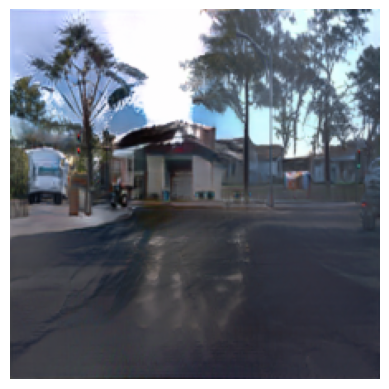

In [77]:
import matplotlib.pyplot as plt

plt.imshow(left_disp[0])
# plt.imshow(front_disp[0])
# plt.imshow(right_disp[0])
plt.axis("off")
plt.show()

In [78]:
overlay_left  = overlay_cam(left_disp,  cam_left, alpha=0.3)
overlay_front = overlay_cam(front_disp, cam_front, alpha=0.3)
overlay_right = overlay_cam(right_disp, cam_right, alpha=0.3)


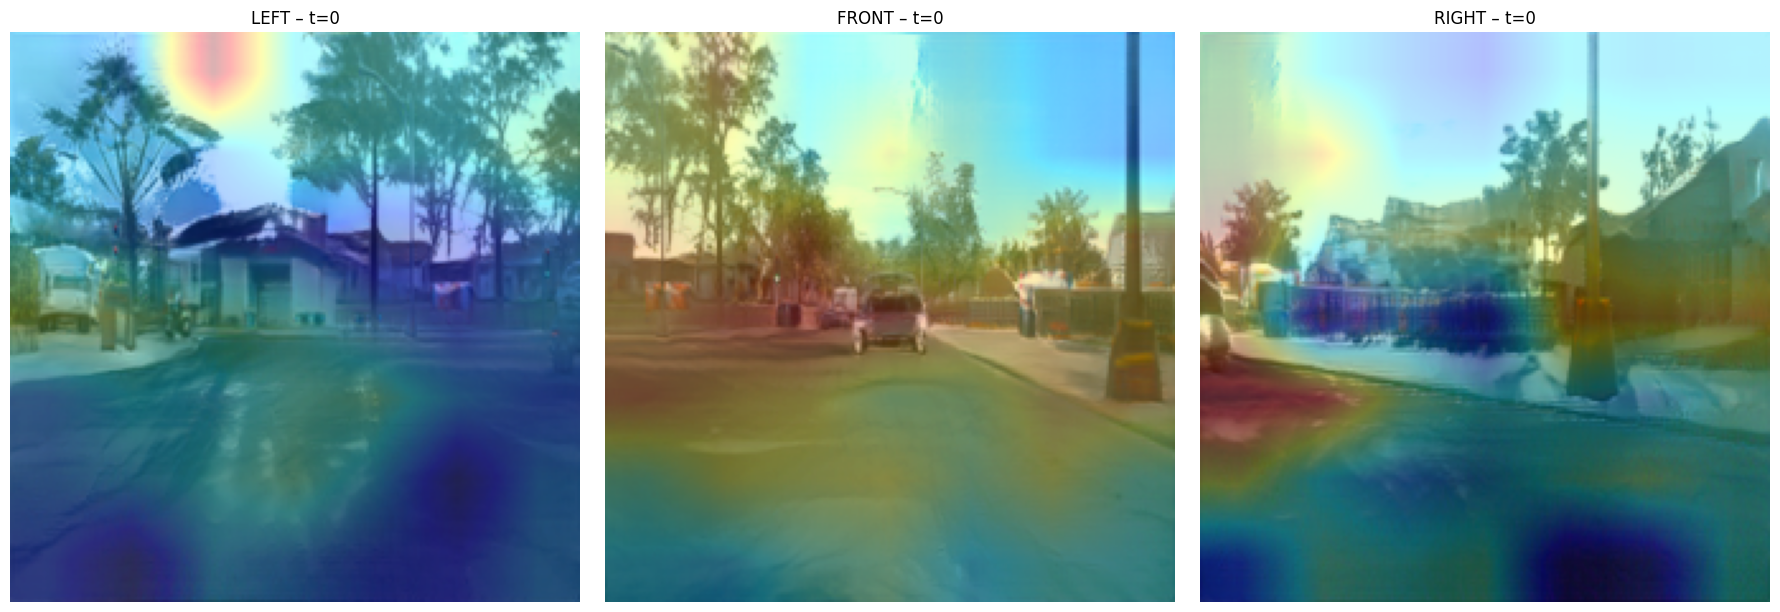

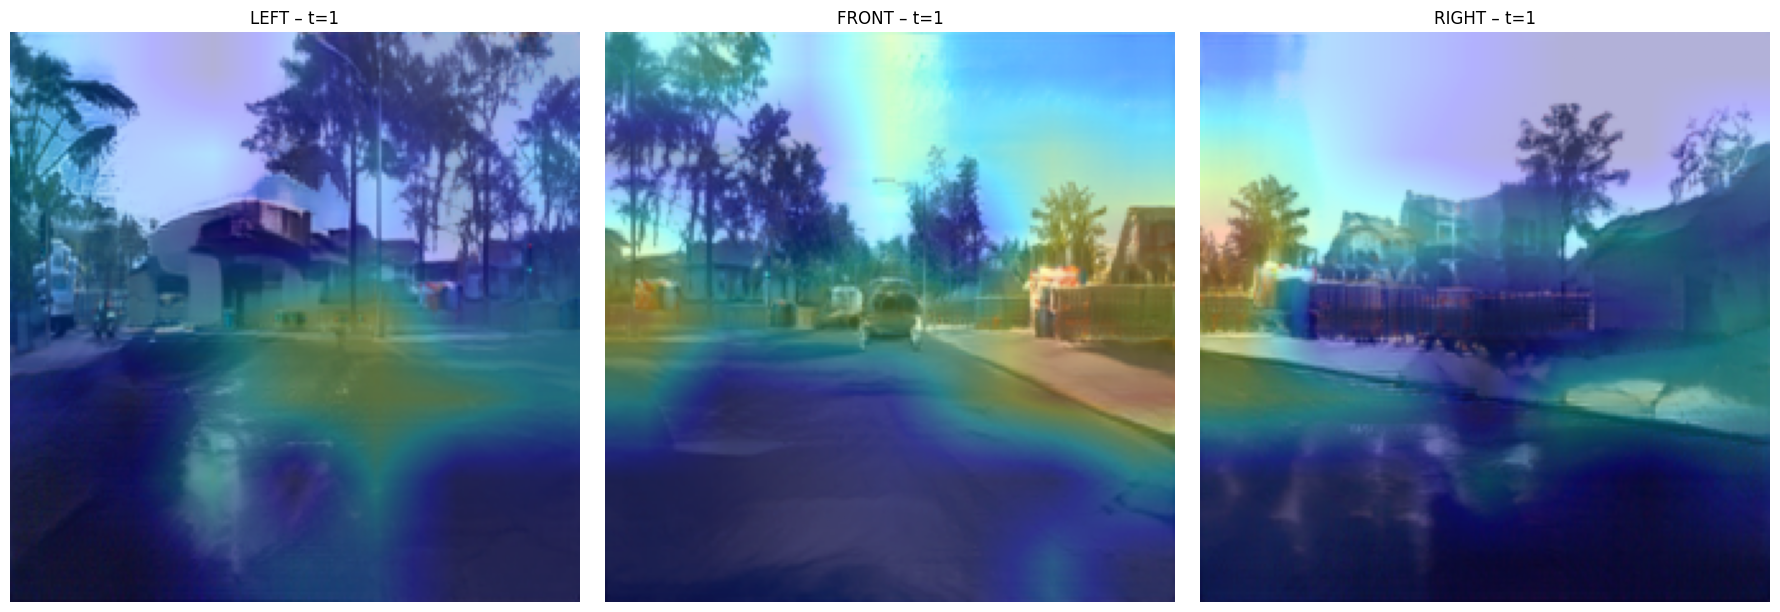

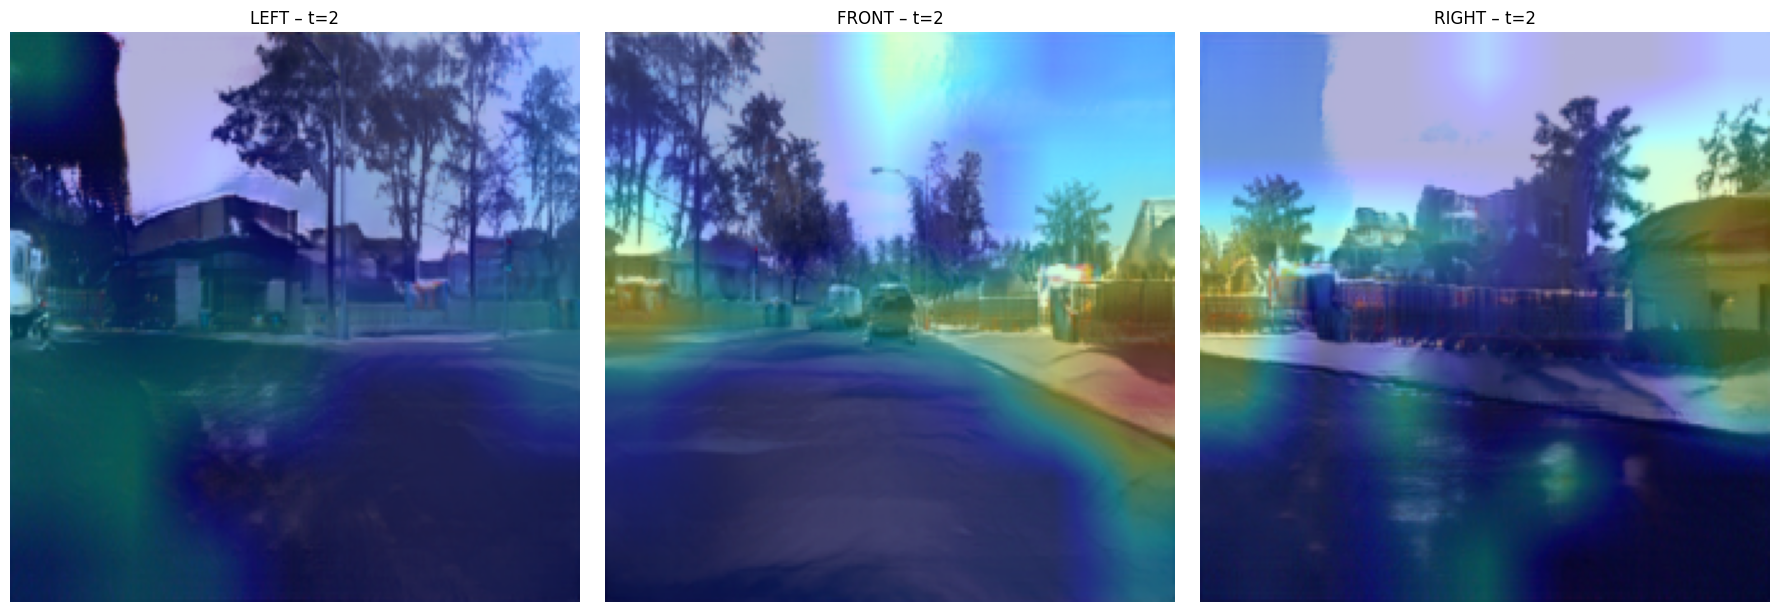

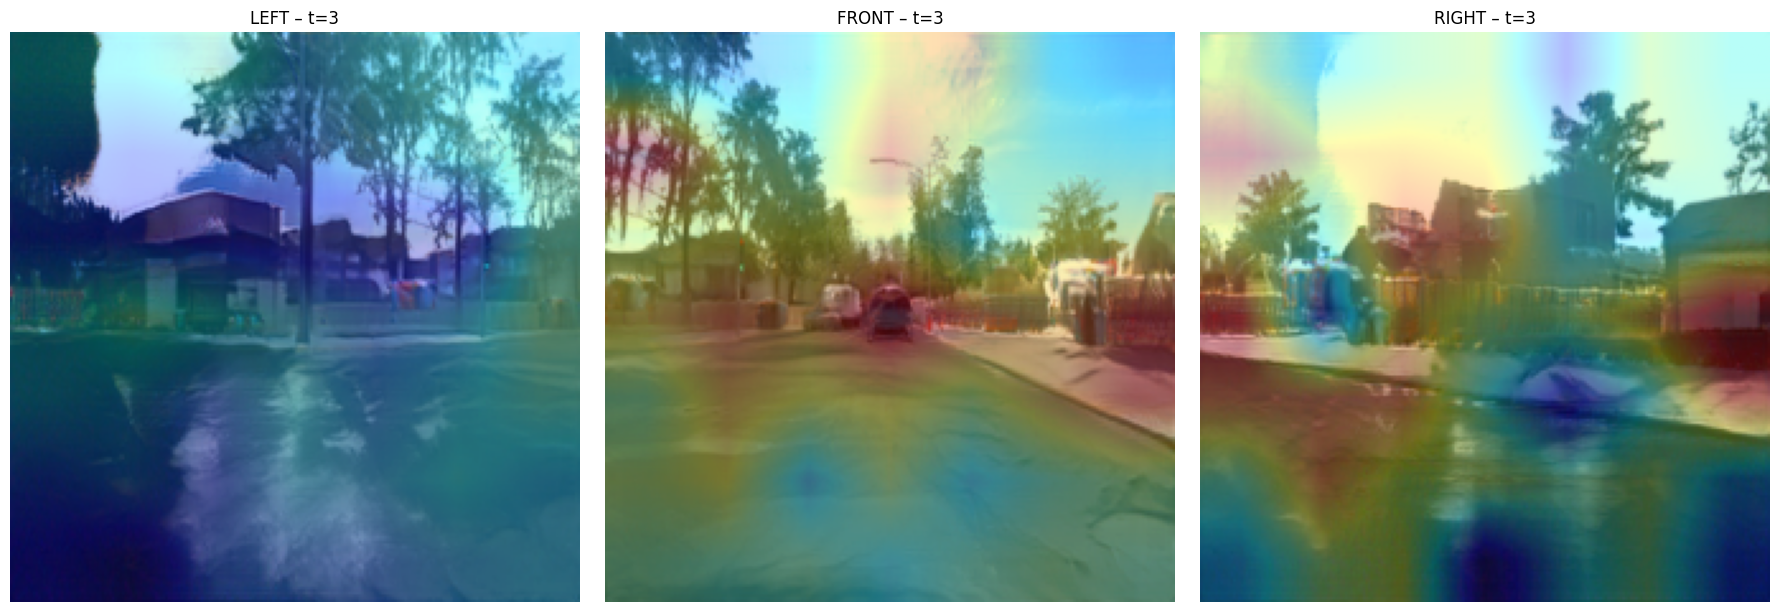

IndexError: list index out of range

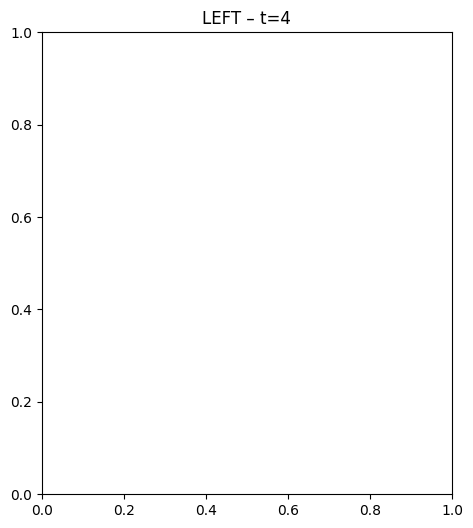

In [79]:
import matplotlib.pyplot as plt

T = left_disp.shape[0]

for t in range(T):
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"LEFT – t={t}")
    plt.imshow(overlay_left[t])
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title(f"FRONT – t={t}")
    plt.imshow(overlay_front[t])
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title(f"RIGHT – t={t}")
    plt.imshow(overlay_right[t])
    plt.axis("off")

    plt.tight_layout()
    plt.show()
